# Assignment 1.2 Stats & Visualization of the Rock Music Network

**Course:** Social Graphs & Visualization  
**Students:** Áróra Hallmundardóttir, Tinna Sól Björgvinsdóttir, and Nanna Kristín Bjarnadóttir

**Goal:** Using the network built in Week 4, we (1) describe how we crawled our network, (2) compute simple network statistics, and (3) produce a basic visualization. 

### 1.a Step by step (what we did)

1) We collected the nodes (performers).  
   We copied the edit wikitext of “List of mainstream rock performers”, used regex to extract `[[Page Title]]` entries, normalized titles to slugs (spaces → `_`, kept things like (band)), and saved them to `data/performers.txt`.

2) We fetched page content.  
   For each slug we called the MediaWiki API (`action=query&prop=revisions&rvslots=main&redirects=1`) with a polite User-Agent and retry logic. Each page was saved in `data/pages/` as one text file.

3) We built directed edges.  
   From each wikitext file we pulled out `[[...]]` links, kept the part before `|` or `#`, skipped anything with a colon, converted to slug form, and only kept it if the target was in our performer list. Every valid link gave us an edge A → B.

4) We added attributes and cleaned the graph.  
   Each node got a content length attribute (word count of wikitext). We removed true isolates (no in- or out-links). In our run this meant one band, *Dr. Hook & the Medicine Show*. Finally, we focused on the largest weakly connected component (LCC), which turned out to be the full graph after cleaning.

5) We did the analysis and visualization.  
   We reported the size of the network (nodes, edges, average degree), plotted degree distributions, compared to random and scale-free baselines, listed top artists by degree, found the longest pages, and drew a layout where node size shows degree and color shows page length.

---

### 1.b What was most difficult

The hardest part was getting titles to match up correctly between filenames, links, and performer names. Handling slashes, underscores, and disambiguators like “(band)” caused some mismatches at first. Filtering to only keep performer-to-performer links was also a bit tricky, since many links point to songs, albums, or categories. Finally, wikitext has quirks like `|` (aliases) and `#` (sections), which needed careful handling.

---

### 1.c How we used LLM help 

We mainly used an LLM for advice on how to normalize titles (slug strategy), for a regex that could handle tricky link formats and for plotting scaffolds like degree histograms. It also suggested ways to export the graph to GraphML/CSV. To make sure things worked, we checked specific pages by hand (like AC/DC), looked at isolates, and confirmed that the top artists in our results matched expectations.

---

### 1.d What we would do differently next time

If we had to do it again, we would probably use a proper wikitext parser instead of regex to avoid edge cases. We would also try to follow redirects more systematically and clean the text before counting words so that the content length attribute is more accurate. 

In [29]:
#Imports
from pathlib import Path
import re, json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [30]:
# Paths & inputs
PERFORMERS_PATH = Path("data/performers.txt")
PAGE_DIR        = Path("data/pages")

# Load performers (allow either titles or slugs; convert to slugs for consistency)
def to_slug(s: str) -> str:
    s = re.sub(r"\s+", " ", s.strip())
    return s.replace(" ", "_")

with PERFORMERS_PATH.open("r", encoding="utf-8") as f:
    performers_raw = [line.strip() for line in f if line.strip()]

performers = [to_slug(x) for x in performers_raw]
performer_set = set(performers)

# Link extractor: [[Target|...]] → Target (before '|' and before '#'), skip namespaces with ':'
LINK_RE = re.compile(r"\[\[([^\[\]]+)\]\]")

def extract_link_targets(wikitext: str):
    targets = set()
    for inner in LINK_RE.findall(wikitext):
        tgt = inner.split("|", 1)[0]   # drop alias
        tgt = tgt.split("#", 1)[0]     # drop section
        if ":" in tgt:                 # skip namespaces (Category:, File:, etc.)
            continue
        targets.add(to_slug(tgt))
    return targets

# Word-count (simple)
WORD_RE = re.compile(r"\b\w+\b", flags=re.UNICODE)
def word_count(txt: str) -> int:
    return len(WORD_RE.findall(txt))


In [31]:
# Build graph + capture isolates + LCC
G = nx.DiGraph()
G.add_nodes_from(performers)

# fill nodes with attributes + edges
for page_path in PAGE_DIR.glob("*.txt"):
    src = page_path.stem.replace(" ", "_")
    if src not in performer_set:
        continue
    wt = page_path.read_text(encoding="utf-8", errors="replace")
    G.nodes[src]["content_length"] = word_count(wt)
    targets = extract_link_targets(wt) & performer_set
    for t in targets:
        if t != src:
            G.add_edge(src, t)

# capture true isolates (save names BEFORE removing them)
isolates = [n for n in G if G.in_degree(n) == 0 and G.out_degree(n) == 0]

# remove true isolates
G.remove_nodes_from(isolates)

# Largest Weakly Connected Component
if G.number_of_edges() > 0 and G.number_of_nodes() > 0:
    lcc_nodes = max(nx.weakly_connected_components(G), key=len)
    G_lcc = G.subgraph(lcc_nodes).copy()
else:
    G_lcc = G.copy()

print(f"Directed graph (post-clean): {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"LCC: {G_lcc.number_of_nodes()} nodes, {G_lcc.number_of_edges()} edges")

# also print isolates for the write-up (pretty names)
print(f"# isolates removed: {len(isolates)}")
for n in isolates:
    print(" -", n.replace("_", " "))


Directed graph (post-clean): 487 nodes, 7346 edges
LCC: 487 nodes, 7346 edges
# isolates removed: 1
 - Dr. Hook & the Medicine Show


### Build summary

- **Directed graph** (after cleaning): 487 nodes, 7,346 edges  
- **Largest weakly connected component** (LCC): 487 nodes, 7,346 edges  

We removed one true isolate: *Dr. Hook & the Medicine Show* (in-degree = 0, out-degree = 0).  
Taking out isolates helps avoid noise in the analysis and visualization.  

In this case the LCC is the same as the whole graph. After removing the isolate, all remaining nodes are connected into one big component once we ignore edge directions.


### 2.a Simple Network Statistics

We now report the basic size of the network and analyze degree distributions.

- **N (nodes):** number of performers.  
- **M (links):** number of directed links between performers.  
- The **average in-degree** equals the **average out-degree** and is `M / N`.


In [32]:
N = G_lcc.number_of_nodes()
M = G_lcc.number_of_edges()
print(f"Nodes (N): {N}")
print(f"Links (M): {M}")
print(f"Average out-degree = Average in-degree = M/N ≈ {M/N:.2f}")


Nodes (N): 487
Links (M): 7346
Average out-degree = Average in-degree = M/N ≈ 15.08


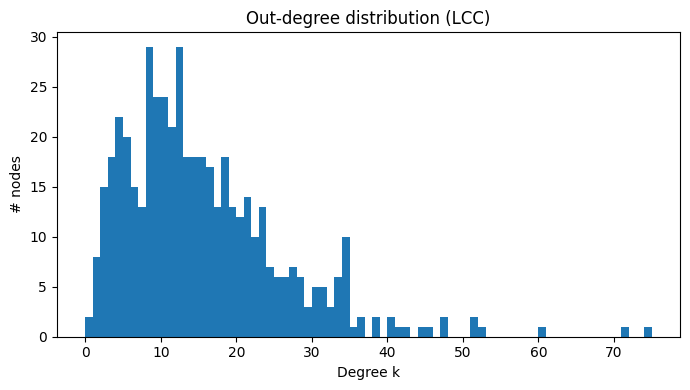

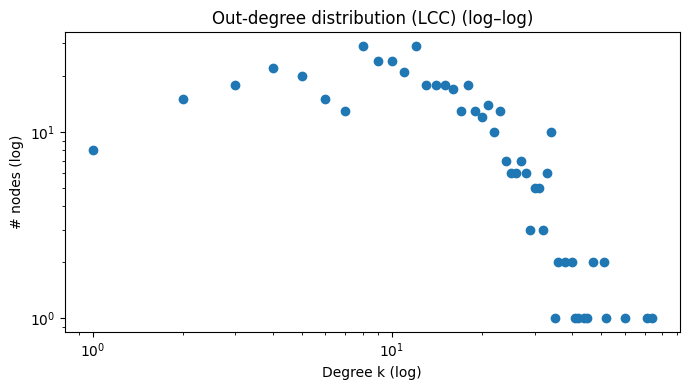

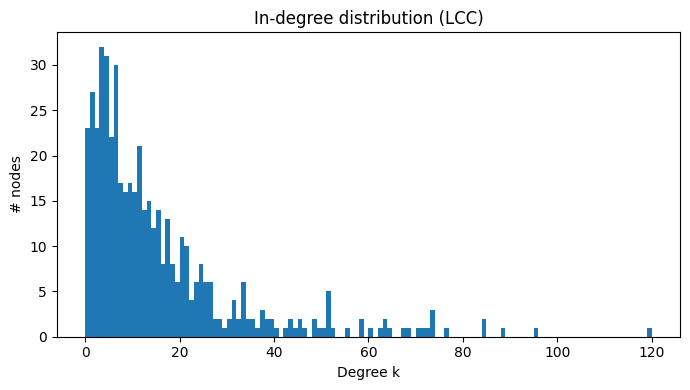

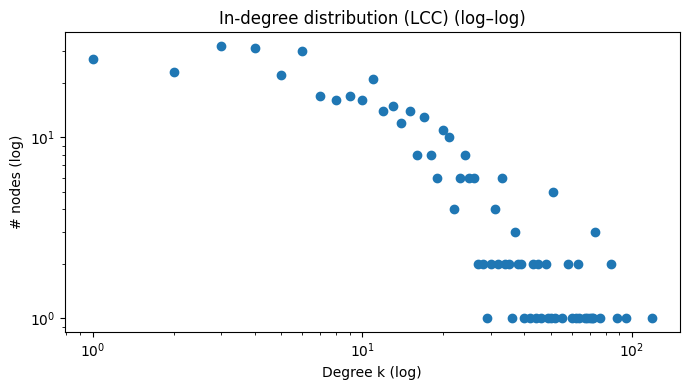

In [33]:
#Degree distributions

nodes = list(G_lcc.nodes())
k_out = np.array([G_lcc.out_degree(n) for n in nodes])
k_in  = np.array([G_lcc.in_degree(n)  for n in nodes])

def plot_degree_hist_int(deg, title):
    kmax = int(deg.max()) if len(deg) else 0
    bins = np.arange(0, kmax + 2)
    counts, edges = np.histogram(deg, bins=bins)
    xs = edges[:-1]

    # linear
    plt.figure(figsize=(7,4))
    plt.bar(xs, counts, width=1.0, align='edge')
    plt.xlabel("Degree k"); plt.ylabel("# nodes"); plt.title(title)
    plt.tight_layout(); plt.show()

    # log–log
    mask = counts > 0
    if mask.any():
        plt.figure(figsize=(7,4))
        plt.loglog(xs[mask], counts[mask], marker='o', linestyle='none')
        plt.xlabel("Degree k (log)"); plt.ylabel("# nodes (log)")
        plt.title(title + " (log–log)")
        plt.tight_layout(); plt.show()

plot_degree_hist_int(k_out, "Out-degree distribution (LCC)")
plot_degree_hist_int(k_in,  "In-degree distribution (LCC)")


### 2.b In/Out-degree distributions - observations

- Out-degree (links made)  
  Most pages link out a modest number of times, with fewer pages linking to dozens of others. On the log–log plot the curve bends downward, so it doesn’t really look power-law. This makes sense since out-degree is limited by page length and editorial style.

- In-degree (links received)  
  The distribution is much more skewed. Many performers only get a few links, but a handful of famous artists receive links from a very large number of pages. On the log–log plot this shows up as a heavier tail, closer to scale-free–like behavior.

- Why they differ  
  Outgoing links are limited by what can reasonably be listed on a single page, while incoming links can build up across the entire network. This creates hub nodes on the in-degree side (like Led Zeppelin, Bob Dylan, Queen, Metallica, and David Bowie), while out-degree stays more bounded.


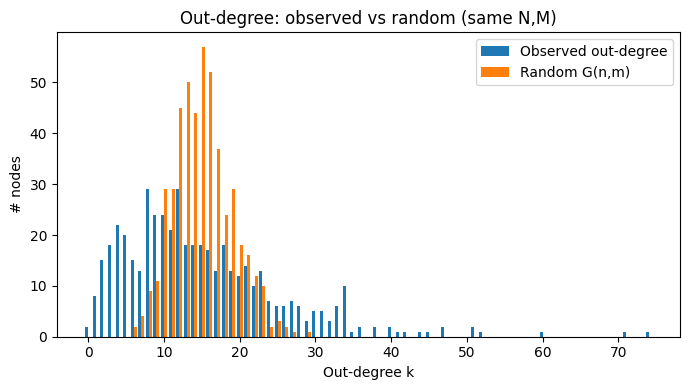

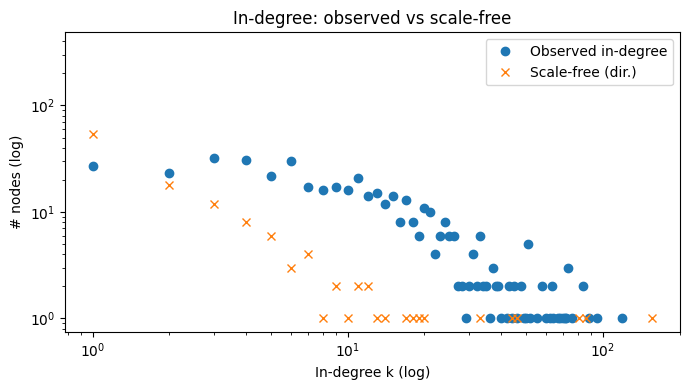

In [34]:
# Random directed G(n, m) for out-degree comparison
N, M = G_lcc.number_of_nodes(), G_lcc.number_of_edges()
Gr = nx.gnm_random_graph(N, M, directed=True, seed=42)
k_out_rand = np.array([Gr.out_degree(n) for n in Gr.nodes()])

kmax = int(max(k_out.max(), k_out_rand.max()))
bins = np.arange(0, kmax + 2)
co, _ = np.histogram(k_out,      bins=bins)
cr, _ = np.histogram(k_out_rand, bins=bins)
xs = bins[:-1]

plt.figure(figsize=(7,4))
plt.bar(xs-0.2, co, width=0.4, label="Observed out-degree")
plt.bar(xs+0.2, cr, width=0.4, label="Random G(n,m)")
plt.xlabel("Out-degree k"); plt.ylabel("# nodes")
plt.title("Out-degree: observed vs random (same N,M)")
plt.legend(); plt.tight_layout(); plt.show()

# Scale-free (directed) for in-degree comparison
SF = nx.scale_free_graph(N, seed=123)      # MultiDiGraph
Gs = nx.DiGraph(SF)                         # merge multiedges
Gs.remove_edges_from(nx.selfloop_edges(Gs))
k_in_sf = np.array([Gs.in_degree(n) for n in Gs.nodes()])

kmax = int(max(k_in.max(), k_in_sf.max()))
bins = np.arange(0, kmax + 2)
ci_obs, _ = np.histogram(k_in,    bins=bins)
ci_sf,  _ = np.histogram(k_in_sf, bins=bins)
xs = bins[:-1]
mo, ms = ci_obs > 0, ci_sf > 0

plt.figure(figsize=(7,4))
plt.loglog(xs[mo], ci_obs[mo], marker='o', linestyle='none', label="Observed in-degree")
plt.loglog(xs[ms], ci_sf[ms],  marker='x', linestyle='none', label="Scale-free (dir.)")
plt.xlabel("In-degree k (log)"); plt.ylabel("# nodes (log)")
plt.title("In-degree: observed vs scale-free")
plt.legend(); plt.tight_layout(); plt.show()


### 2.c Comparisons to baselines

- Out-degree vs random G(n, m)  
  In the random graph the out-degree is tightly centered around the mean, while in our network it’s more spread out with a longer tail. This means some performer pages link out much more than average, which a random model doesn’t capture.

- In-degree vs scale-free  
  Compared to a scale-free network, our in-degree also shows hubs and a heavy tail, but it’s not as extreme as the pure scale-free case. This matches the idea that a few very famous artists attract lots of links, while most get only a few.

**Takeaway**  
The network is clearly not random. Out-degree is shaped by how each page is written, while in-degree reflects hub structure with a handful of iconic performers dominating incoming links.


### 2.d Top nodes and longest pages

To get a feel for the network, we looked at which performers link out the most, which ones get linked to the most, and which pages are simply the longest.


In [35]:
def top_k_degree(G, k=5):
    top_out = sorted(G.out_degree(), key=lambda x: (x[1], x[0]), reverse=True)[:k]
    top_in  = sorted(G.in_degree(),  key=lambda x: (x[1], x[0]), reverse=True)[:k]
    return top_out, top_in

top_out, top_in = top_k_degree(G_lcc, k=5)

print("Top 5 by OUT-degree (links made):")
for name, deg in top_out:
    print(f"  {name.replace('_', ' '):40s}  {deg}")

print("\nTop 5 by IN-degree (links received):")
for name, deg in top_in:
    print(f"  {name.replace('_', ' '):40s}  {deg}")

# Longest pages by content_length
CONTENT_ATTR = "content_length"
# fallback fill if any node missed the attribute
for n in G_lcc.nodes():
    G_lcc.nodes[n][CONTENT_ATTR] = G_lcc.nodes[n].get(CONTENT_ATTR, 0)

items = [(n, G_lcc.nodes[n][CONTENT_ATTR]) for n in G_lcc.nodes()]
items.sort(key=lambda x: x[1], reverse=True)

print("\nTop 10 pages by content length (approx word count):")
for i, (name, L) in enumerate(items[:10], 1):
    print(f"{i:2d}. {name.replace('_', ' '):40s}  {L:>8,d}")


Top 5 by OUT-degree (links made):
  Alice in Chains                           74
  Deep Purple                               71
  Black Sabbath                             60
  Def Leppard                               52
  Guns N' Roses                             51

Top 5 by IN-degree (links received):
  Led Zeppelin                              119
  Bob Dylan                                 95
  Queen (band)                              88
  Metallica                                 84
  David Bowie                               84

Top 10 pages by content length (approx word count):
 1. Guns N' Roses                               60,850
 2. Coldplay                                    47,026
 3. Queen (band)                                46,175
 4. Marilyn Manson (band)                       46,032
 5. The Rolling Stones                          44,022
 6. U2                                          43,048
 7. Bob Dylan                                   42,510
 8. David Bowie    

The results make sense.  

- The big out linkers (Alice in Chains, Deep Purple, Black Sabbath) are pages that reference lots of other acts.  
- The in link hubs (Led Zeppelin, Bob Dylan, Queen, Metallica, David Bowie) are basically the iconic artists everyone mentions.  
- The longest pages are huge bands with long careers and big followings (Guns N’ Roses, Queen, The Rolling Stones, U2, etc.) which explains the word counts in the tens of thousands.

So overall, the lists highlight the expected “giants” of rock, both in terms of influence (in-degree) and in terms of article detail (page length).


## 3. Simple visualization (undirected)

We also drew the undirected version of the network to get a quick visual overview.  

- Node size shows degree, so the larger nodes are the more connected performers.  
- Node color is based on the log of page length, with darker shades meaning longer Wikipedia articles.  
- We used a spring layout, which spreads nodes into a roughly circular structure. With almost 500 performers it still looks dense, but some patterns stand out.  

A few big nodes clearly pop out as hubs, matching the in-degree results we saw earlier. The color scale also highlights which artists have especially long articles, often overlapping with the major hubs. Even though the figure is a bit of a “hairball,” it still confirms the skew in the degree distribution and shows where the centers of attention are in the network.


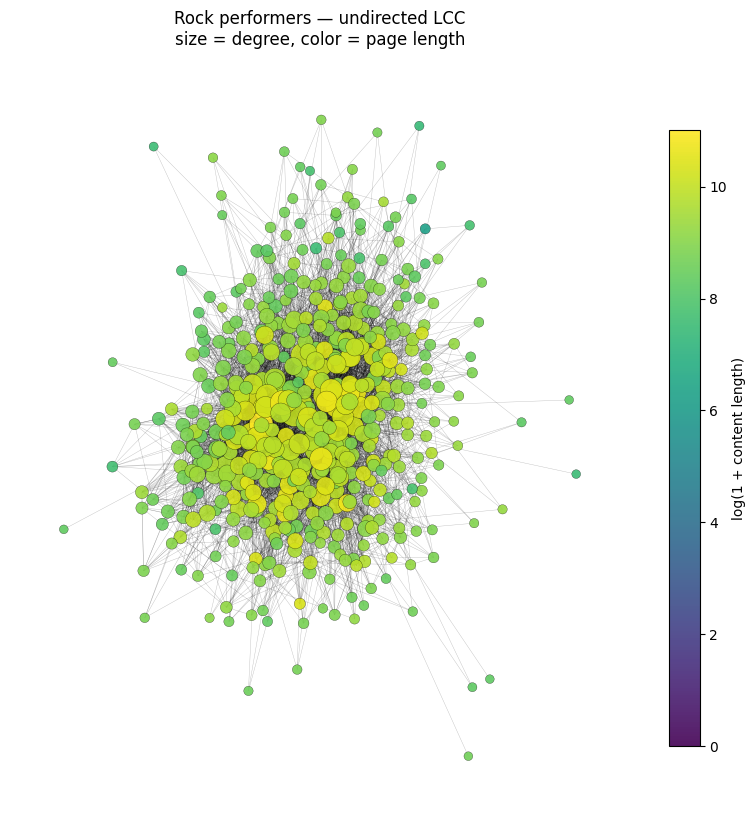

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# --- graph to plot (undirected LCC) ---
H = G_lcc.to_undirected()

# Reuse an existing layout if available; otherwise make one
if "pos" in locals() and set(pos.keys()) == set(H.nodes()):
    layout = pos
else:
    layout = nx.spring_layout(H, seed=7)  # or: nx.kamada_kawai_layout(H)

# --- node sizes → degree (rescaled nicely) ---
deg = dict(H.degree())
deg_vals = np.array([deg[n] for n in H.nodes()])

def rescale(arr, new_min=20, new_max=300):
    arr = np.asarray(arr, dtype=float)
    rng = arr.max() - arr.min()
    if rng == 0:
        return np.full_like(arr, (new_min + new_max) / 2.0)
    return new_min + (arr - arr.min()) * (new_max - new_min) / (rng + 1e-9)

node_sizes = rescale(deg_vals, new_min=40, new_max=400)

# --- node colors → log-scaled content length ---
# prefer "content_length", fall back to "content_len"
content_attr = "content_length" if any("content_length" in G_lcc.nodes[n] for n in G_lcc.nodes()) else "content_len"
content_raw = np.array([G_lcc.nodes[n].get(content_attr, 0) for n in H.nodes()])
colors = np.log1p(content_raw)  # smooths huge pages while keeping order

# --- draw ---
plt.figure(figsize=(10, 10))
nodes = nx.draw_networkx_nodes(
    H, layout,
    node_size=node_sizes,
    node_color=colors,
    cmap="viridis",     # simple sequential colormap
    edgecolors="k",
    linewidths=0.2,
    alpha=0.9,
)
nx.draw_networkx_edges(H, layout, width=0.3, alpha=0.25)

cb = plt.colorbar(nodes, shrink=0.8)
cb.set_label("log(1 + content length)")

plt.title("Rock performers — undirected LCC\nsize = degree, color = page length")
plt.axis("off")
plt.show()


## 4. Loading the dataset from GitHub (for grading)

We saved the largest component as GraphML and pushed it to GitHub. The cell below loads the graph directly from a GitHub Raw URL so the notebook can reproduce our results without local files. If the URL isn’t set or reachable, we fall back to the local `exports/rock_network_lcc.graphml`.


In [37]:
from pathlib import Path
import networkx as nx

# make sure the folder exists
OUT_DIR = Path("exports")
OUT_DIR.mkdir(exist_ok=True)

# save the largest component
nx.write_graphml(G_lcc, OUT_DIR / "rock_network_lcc.graphml")

print("Saved to:", OUT_DIR / "rock_network_lcc.graphml")


Saved to: exports/rock_network_lcc.graphml
